# Lesson 1 - Are you a distracted driver?
# Kaggle competition sample

Try to address the Synthetic Digits dataset using concepts from lesson1/v3

https://www.kaggle.com/c/state-farm-distracted-driver-detection


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

# Prerequisite: install kaggle api

Follow instructions on https://github.com/Kaggle/kaggle-api

The main steps are installing the cli ("pip install kaggle") and setting up your credentials on ~/.kaggle/kaggle.json

## Download competition dataset from kaggle

The following steps are valid for almost any kaggle competition.

In [3]:
#Prepare dataset props
competition_name='state-farm-distracted-driver-detection' # this is the kaggle dataset name
dest_folder_name='distracted-driver' # sub folder of fast.ai data folder

In [4]:
#Prepare params
from fastai.datasets import datapath4file
path = datapath4file(f'{(dest_folder_name)}')
dest_folder = path.as_posix()
print(dest_folder)

/home/ste/.fastai/data/distracted-driver


Call kaggle cli to download dataset and unzip it. 

In [ ]:
# Call kaggle cli to download competition
!kaggle competitions download -c {competition_name} -p {dest_folder}

Take a look of what's inside...

In [5]:
!ls -l {dest_folder}

total 4215220
-rw-r--r--  1 ste ste     491359 apr  7  2016 driver_imgs_list.csv
-rw-rw-r--  1 ste ste      95118 ott 23 15:19 driver_imgs_list.csv.zip
-rw-rw-r--  1 ste ste 4292669227 ott 23 15:19 imgs.zip
drwxrwxr-x  2 ste ste       4096 ott 26 01:54 models
-rw-rw-r--  1 ste ste    4298269 giu 21 00:16 sample_submission.csv
-rw-rw-r--  1 ste ste     197611 ott 23 15:08 sample_submission.csv.zip
-rw-rw-r--  1 ste ste   11364440 ott 25 21:30 submission.csv
-rw-rw-r--  1 ste ste    4530371 ott 26 08:39 submission.csv.gz
drwxr-xr-x  2 ste ste    2711552 ott 23 17:16 test
drwxr-xr-x 12 ste ste       4096 mar 29  2016 train


Let's unzip the needed files...

In [ ]:
#Unzip
!unzip -o -q {dest_folder}/driver_imgs_list.csv.zip -d {dest_folder}
!unzip -o -q {dest_folder}/imgs.zip -d {dest_folder}
!unzip -o -q {dest_folder}/sample_submission.csv.zip -d {dest_folder}

## Looking at the data

Classes:
* c0: safe driving
* c1: texting - right
* c2: talking on the phone - right
* c3: texting - left
* c4: talking on the phone - left
* c5: operating the radio
* c6: drinking
* c7: reaching behind
* c8: hair and makeup
* c9: talking to passenger

In [6]:
# Create description dictionary to decode classes
description_dict = {"c0": "safe driving","c1": "texting - right","c2": "talking on the phone - right","c3": "texting - left","c4": "talking on the phone - left","c5": "operating the radio","c6": "drinking","c7": "reaching behind","c8": "hair and makeup","c9": "talking to passenger"}

In [7]:
#Define paths
path_train = path/'train'
path_test = path/'test'

In [8]:
# Training set:
print('Training set folders: ', path_train.ls())

Training set folders:  [PosixPath('/home/ste/.fastai/data/distracted-driver/train/c5'), PosixPath('/home/ste/.fastai/data/distracted-driver/train/c4'), PosixPath('/home/ste/.fastai/data/distracted-driver/train/c7'), PosixPath('/home/ste/.fastai/data/distracted-driver/train/c8'), PosixPath('/home/ste/.fastai/data/distracted-driver/train/c6'), PosixPath('/home/ste/.fastai/data/distracted-driver/train/c2'), PosixPath('/home/ste/.fastai/data/distracted-driver/train/c9'), PosixPath('/home/ste/.fastai/data/distracted-driver/train/c1'), PosixPath('/home/ste/.fastai/data/distracted-driver/train/c0'), PosixPath('/home/ste/.fastai/data/distracted-driver/train/c3')]


In [9]:
# test set:
print('Test set files count: ', len(path_test.ls()))

Test set files count:  79726


In [10]:
print('dataset rows: ' + str(len(path_test.ls())))
print('sample: ', path_test.ls()[:10])

dataset rows: 79726
sample:  [PosixPath('/home/ste/.fastai/data/distracted-driver/test/img_44563.jpg'), PosixPath('/home/ste/.fastai/data/distracted-driver/test/img_24158.jpg'), PosixPath('/home/ste/.fastai/data/distracted-driver/test/img_69173.jpg'), PosixPath('/home/ste/.fastai/data/distracted-driver/test/img_21453.jpg'), PosixPath('/home/ste/.fastai/data/distracted-driver/test/img_12083.jpg'), PosixPath('/home/ste/.fastai/data/distracted-driver/test/img_49408.jpg'), PosixPath('/home/ste/.fastai/data/distracted-driver/test/img_80686.jpg'), PosixPath('/home/ste/.fastai/data/distracted-driver/test/img_9258.jpg'), PosixPath('/home/ste/.fastai/data/distracted-driver/test/img_98345.jpg'), PosixPath('/home/ste/.fastai/data/distracted-driver/test/img_90161.jpg')]


## Create DataBunch 'from_lists' and take a look

The following steps shows how to create a DataBunch from a single "train" folder with class subfolders.
The validation set is made from a percentage of train images.

IMPORTANT: during experiments we take a sub sample (10%) of whole dataset (train,valid), to decrease iteration time and test different approaches.
For the final training we skip the "DATASET REDUCTION" cell to train our model with the whole dataset.

In [11]:
# Flat operator for list:
# Transform List[List[a]] -> List[a]
flat_list = lambda l: [item for sublist in l for item in sublist] # flat operator for list

In [12]:
# Create list of all files
all_files = flat_list([d.glob('*') for d in path_train.glob('*')])
np.random.shuffle(all_files) # Ensure no bias from ordering
print('Files count: ' + str(len(all_files)))
print('sample: ', all_files[:10])
files = all_files # Assign files scope to all

Files count: 22424
sample:  [PosixPath('/home/ste/.fastai/data/distracted-driver/train/c2/img_10983.jpg'), PosixPath('/home/ste/.fastai/data/distracted-driver/train/c2/img_74452.jpg'), PosixPath('/home/ste/.fastai/data/distracted-driver/train/c1/img_63522.jpg'), PosixPath('/home/ste/.fastai/data/distracted-driver/train/c1/img_60705.jpg'), PosixPath('/home/ste/.fastai/data/distracted-driver/train/c1/img_54188.jpg'), PosixPath('/home/ste/.fastai/data/distracted-driver/train/c4/img_75950.jpg'), PosixPath('/home/ste/.fastai/data/distracted-driver/train/c2/img_38038.jpg'), PosixPath('/home/ste/.fastai/data/distracted-driver/train/c5/img_57852.jpg'), PosixPath('/home/ste/.fastai/data/distracted-driver/train/c1/img_44158.jpg'), PosixPath('/home/ste/.fastai/data/distracted-driver/train/c5/img_30018.jpg')]


**IMPORTANT**: during experimentation we take sub-sample of complete list to iterate quickly.

In [ ]:
#### DATASET REDUCTION ###
# Select subset for test covergence
# IMPORTANT: skip this cell in final training
import random
items_count = int(len(all_files) * .1)
files = random.sample(all_files,items_count)

print('Files count: ' + str(len(files)))

In [13]:
# Support function: extract class from file name
extractClass = lambda l: Path(l[l.rfind('train')+len('train')+1:]).parent.as_posix()
# Usage sample
print(extractClass('/home/xxx/.fastai/data/distracted-driver/train/c5/img_82866.jpg'))

c5


In [14]:
# Compute labels for all files
labels = list(map(extractClass, map(Path.as_posix, files)))
print('Sample 1: ', list(labels)[:10])
print('Sample 2: ', list(labels)[-10:])

Sample 1:  ['c2', 'c2', 'c1', 'c1', 'c1', 'c4', 'c2', 'c5', 'c1', 'c5']
Sample 2:  ['c8', 'c4', 'c5', 'c3', 'c8', 'c2', 'c3', 'c2', 'c8', 'c7']


### Data augmentation 

We choose the correct data augmentation transformations to focus on real samples.
Taking a look at the dataset we can see that all the pictures are oriented in the same way and so we disable horizontal and vertical flipping.

IMPORTANT: we're using a model pre-trained on imagenet, so it's important to normalize input images accordingly.

In [15]:
# Create data augmentation:
tfms = get_transforms(flip_vert=False, do_flip=False, max_zoom=1.0) # Tune data augmentation
# NB: use 20% of train set as validation set
data = ImageDataBunch.from_lists(path=path, fnames=files, labels=labels, valid_pct=0.2, test='test', ds_tfms=tfms, size=256, bs=32)
data.normalize(imagenet_stats)

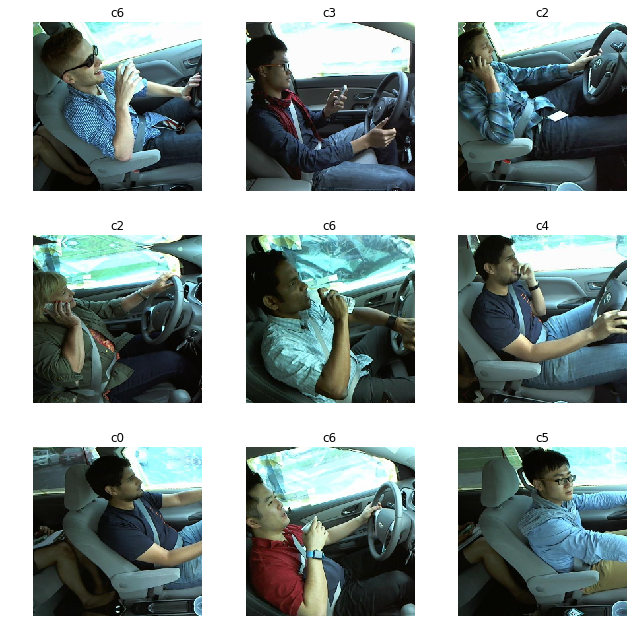

In [16]:
data.show_batch(rows=3, figsize=(9,9), is_train=True)

In [17]:
# Sort and Show classes
#data.classes.sort() # Sort in place
print('Classes: ',data.classes)
print('len: ',len(data.classes),data.c)

Classes:  ['c2', 'c1', 'c4', 'c5', 'c0', 'c7', 'c6', 'c8', 'c9', 'c3']
len:  10 10


## Training: resnet50

In [20]:
# TODO: switch from error_rate to logloss metric according to competition requirements...
learn = create_cnn(data, models.resnet50, metrics=error_rate)

Fit the first epochs using high learning rate

In [21]:
learn.fit_one_cycle(cyc_len=5, max_lr=slice(1e-3))

Total time: 10:59
epoch  train_loss  valid_loss  error_rate
1      0.427919    0.167032    0.046686    (02:14)
2      0.161980    0.069214    0.018498    (02:11)
3      0.101866    0.046943    0.011671    (02:11)
4      0.059119    0.039186    0.011892    (02:11)
5      0.042949    0.034064    0.009469    (02:11)



In [22]:
learn.save('last-50-v2')

Some more epochs...

In [23]:
learn.fit_one_cycle(cyc_len=2, max_lr=slice(1e-3))

Total time: 04:22
epoch  train_loss  valid_loss  error_rate
1      0.062381    0.034054    0.009249    (02:11)
2      0.048147    0.027821    0.006386    (02:11)



In [24]:
learn.save('last-50-v2')

In [25]:
learn.fit_one_cycle(cyc_len=2, max_lr=slice(1e-3))

Total time: 04:23
epoch  train_loss  valid_loss  error_rate
1      0.052814    0.033914    0.008368    (02:11)
2      0.033222    0.026424    0.006166    (02:11)



In [26]:
learn.save('last-50-v2')

## Unfreeze and use Lr Finder

In [33]:
learn.load('last-50-v2')

In [39]:
# Take a look to layers...
learn.layer_groups

[Sequential(
   (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (2): ReLU(inplace)
   (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (4): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (8): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (10): ReLU(inplace)
   (11): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
   (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (13): Conv2d(256, 64, kernel_

In [66]:
zzz = learn.layer_groups[2]
??zzz[2]

In [40]:
# Unfreeze 50% of layers 
learn.freeze_to(27)

In [41]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


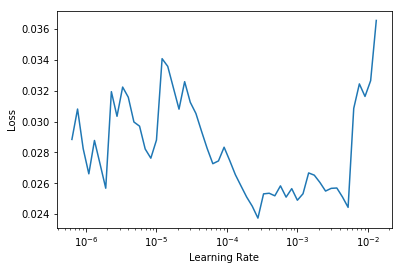

In [42]:
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(5, max_lr=slice(1e-5,1e-4))

Total time: 10:55
epoch  train_loss  valid_loss  error_rate
1      0.030377    0.026758    0.006386    (02:10)
2      0.032521    0.025096    0.005065    (02:11)
3      0.025869    0.024331    0.005285    (02:11)
4      0.023872    0.024716    0.005285    (02:11)
5      0.028622    0.024720    0.005065    (02:11)



In [50]:
learn.save('last-50-v2')

In [51]:
learn.fit_one_cycle(2, max_lr=slice(1e-4))

Total time: 04:21
epoch  train_loss  valid_loss  error_rate
1      0.023152    0.024123    0.004845    (02:10)
2      0.032000    0.024298    0.005505    (02:11)



In [53]:
learn.save('last-50-v2')

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


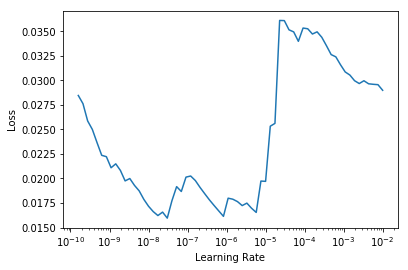

In [52]:
learn.lr_find(start_lr=1e-11)
learn.recorder.plot()

In [54]:
learn.fit_one_cycle(5, max_lr=slice(5e-10,1e-8))

Total time: 10:54
epoch  train_loss  valid_loss  error_rate
1      0.018760    0.023525    0.004625    (02:10)
2      0.030263    0.024544    0.005065    (02:11)
3      0.020396    0.023859    0.005726    (02:11)
4      0.022093    0.023457    0.004625    (02:11)
5      0.026630    0.023568    0.004845    (02:11)



In [81]:
learn.save('last-50-v2')

Stating to overfit so we stop.

## Results

In [56]:
interp = ClassificationInterpretation.from_learner(learn)

In [57]:
r = interp.most_confused(min_val=0)
print(r)

[('c4', 'c3', 3), ('c9', 'c8', 3), ('c3', 'c0', 3), ('c0', 'c9', 2), ('c2', 'c6', 1), ('c2', 'c8', 1), ('c1', 'c0', 1), ('c4', 'c2', 1), ('c5', 'c0', 1), ('c5', 'c8', 1), ('c7', 'c0', 1), ('c8', 'c9', 1), ('c9', 'c7', 1), ('c9', 'c6', 1), ('c3', 'c4', 1)]


In [58]:
number_of_errors = sum(map(lambda x: x[2], r))
number_of_test_items = interp.losses.size()[0]
e = number_of_errors/number_of_test_items
print(f'{number_of_errors}/{number_of_test_items} = {e}')

22/4541 = 0.004844747852895838


**That's an incredible result!**

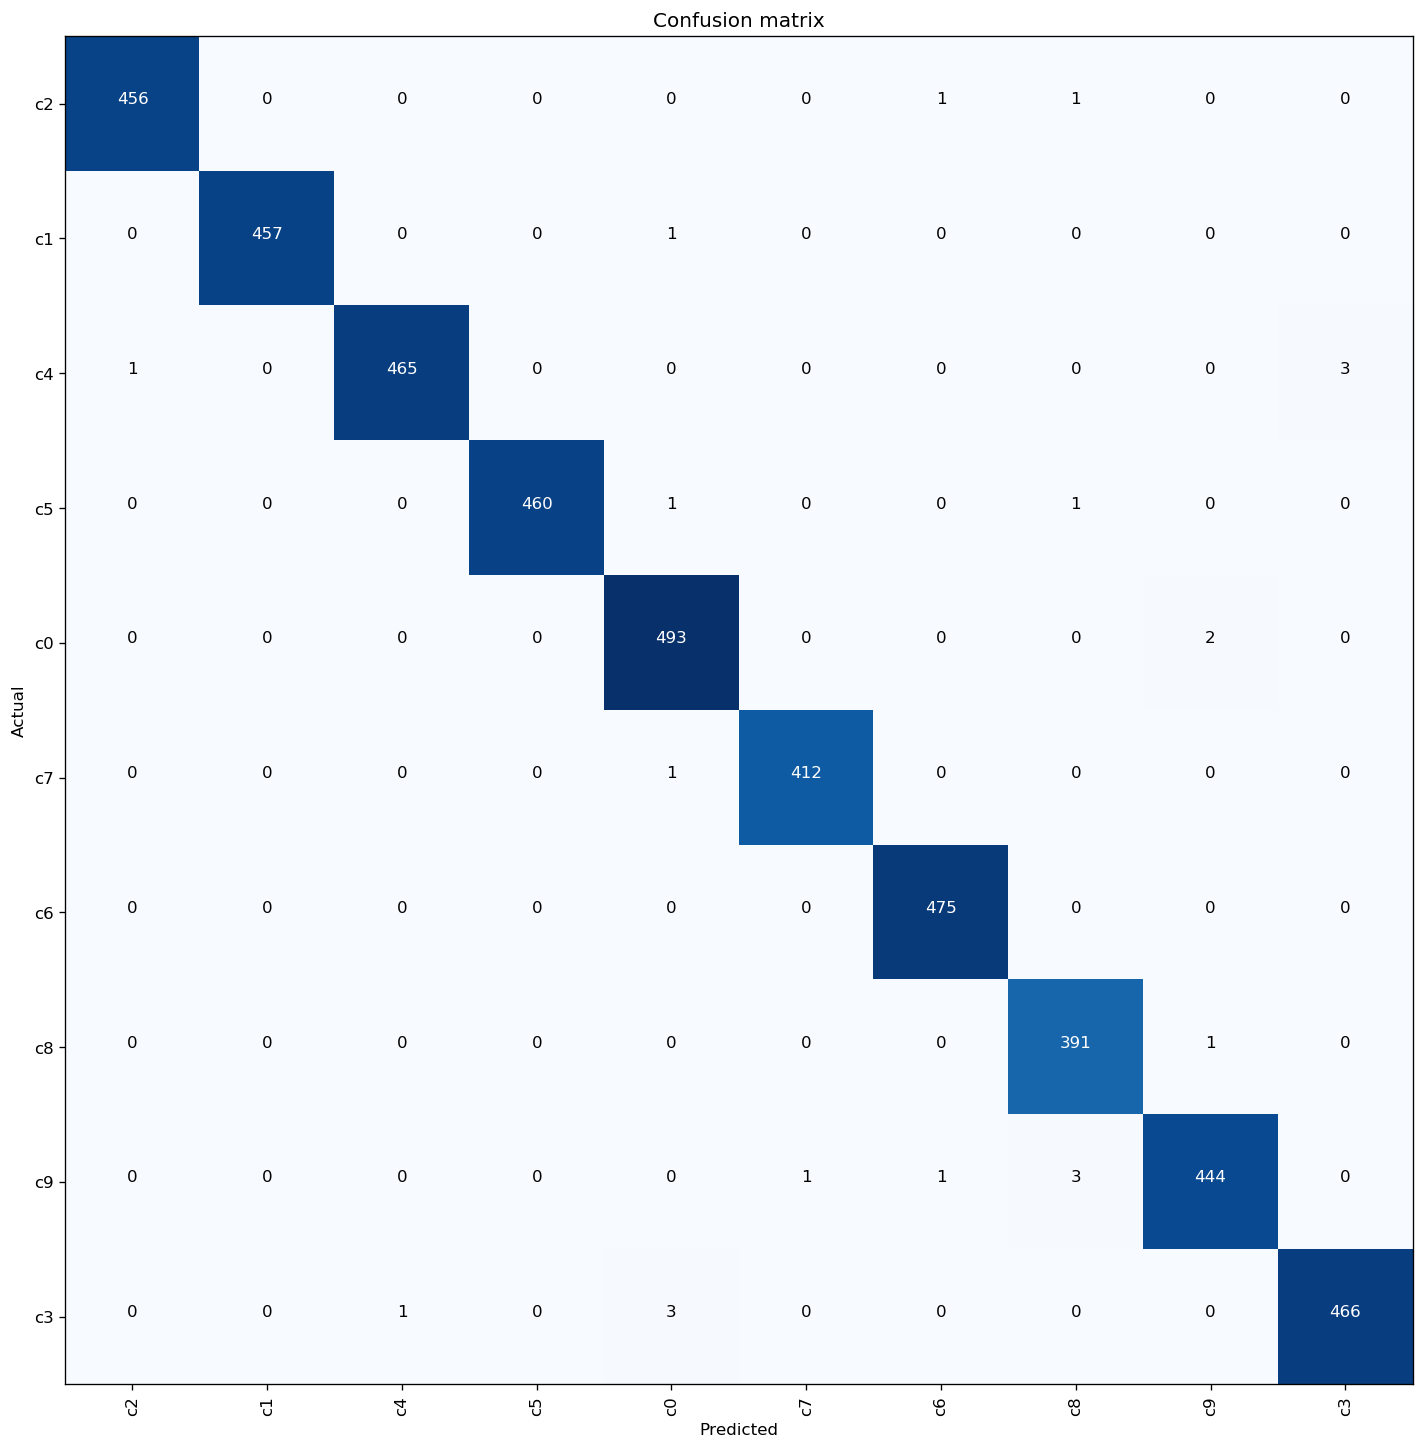

In [59]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=120)

## Create submission

The following steps shows how to process 80k test images and create a submission.

In [60]:
preds = learn.TTA(is_test=True, scale=1.0)[0]

Total time: 32:18



In [67]:
print('Images to test: ',np.shape(data.test_dl.dl.dataset.x)[0])
print('Predictions: ',np.shape(preds.numpy()))

Images to test:  79726
Predictions:  (79726, 10)


In [68]:
# Find file name
preds_name = [(path.name) for path in data.test_dl.dl.dataset.x]
preds_name[:10]

['img_44563.jpg',
 'img_24158.jpg',
 'img_69173.jpg',
 'img_21453.jpg',
 'img_12083.jpg',
 'img_49408.jpg',
 'img_80686.jpg',
 'img_9258.jpg',
 'img_98345.jpg',
 'img_90161.jpg']

In [69]:
# Preds vals...
preds_val = preds.numpy()
preds_val[0,:]

array([1.500584e-02, 2.752963e-03, 1.579923e-04, 1.167549e-04, 3.061368e-04, 6.787307e-04, 9.797816e-01, 2.381548e-04,
       3.797836e-06, 9.580495e-04], dtype=float32)

In [70]:
# Sort classes
sorted_classes = sorted(data.classes)
sorted_classes

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [71]:
# Find best prediction
preds_id = (preds.argmax(dim=1)).numpy()
preds_id[:15]

array([6, 4, 2, 6, 2, 1, 9, 2, 3, 4, 0, 6, 3, 1, 5])

In [72]:
# Get correct class
preds_classes = list(map(lambda id: data.classes[id], preds_id)) # Use original classes order
preds_classes[:10]

['c6', 'c0', 'c4', 'c6', 'c4', 'c1', 'c3', 'c4', 'c5', 'c0']

## Analyze predictions

Take a look at predictions befor to create submission.

In [73]:
df = pd.DataFrame({'name': preds_name, 'path':data.test_dl.dl.dataset.x, 'cls': preds_classes})
df['desc'] = df.cls.map(lambda c: description_dict[c])
df.head()

,name,path,cls,desc
0,img_44563.jpg,/home/ste/.fastai/data/distracted-driver/test/...,c6,drinking
1,img_24158.jpg,/home/ste/.fastai/data/distracted-driver/test/...,c0,safe driving
2,img_69173.jpg,/home/ste/.fastai/data/distracted-driver/test/...,c4,talking on the phone - left
3,img_21453.jpg,/home/ste/.fastai/data/distracted-driver/test/...,c6,drinking
4,img_12083.jpg,/home/ste/.fastai/data/distracted-driver/test/...,c4,talking on the phone - left


'img_44563.jpg : drinking'

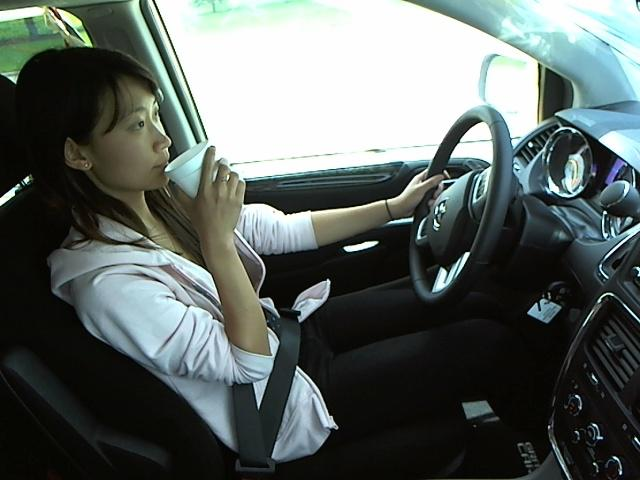

'img_24158.jpg : safe driving'

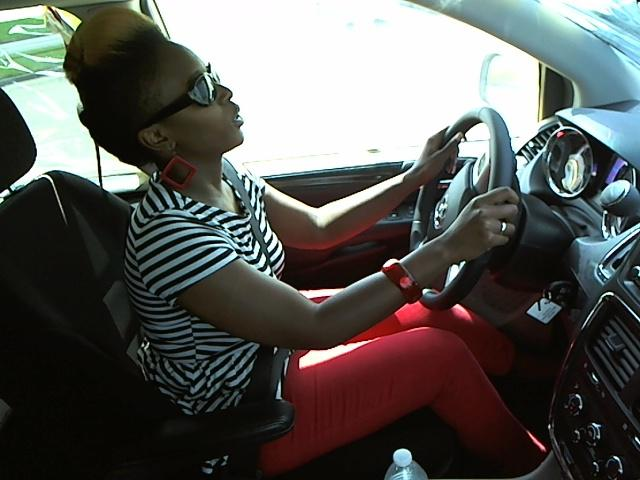

'img_69173.jpg : talking on the phone - left'

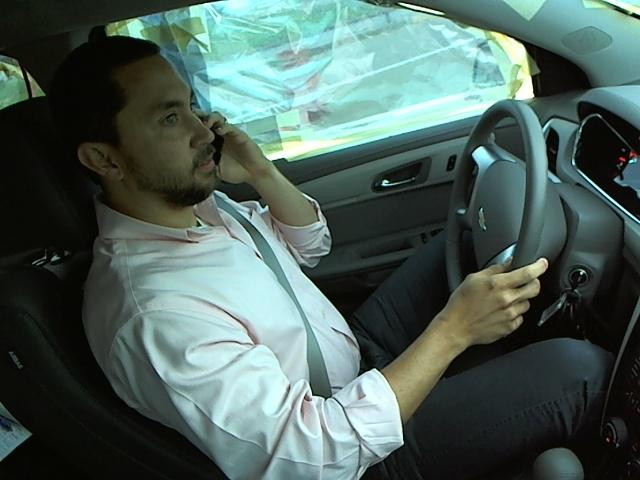

In [55]:
import IPython
for index, row in df[0:3].iterrows():
    display(row['name'] + ' : ' + row.desc)
    display(IPython.display.Image(filename=row.path.as_posix()))

## Softmax for probability

The competition requires probability for submission, so let's convert predictions to probability distribution using softmax.

In [74]:
# Actual Preds:
preds_final = preds.numpy()
print(preds_final[:10])

[[1.500584e-02 2.752963e-03 1.579923e-04 1.167549e-04 ... 9.797816e-01 2.381548e-04 3.797836e-06 9.580495e-04]
 [2.943224e-04 1.118463e-03 2.227919e-04 3.991973e-03 ... 1.758177e-04 8.302810e-04 1.877880e-02 4.406644e-05]
 [4.466913e-03 1.751647e-03 8.735539e-01 4.348479e-04 ... 7.815684e-03 7.384120e-02 3.972838e-03 1.130751e-03]
 [9.413995e-02 3.693667e-04 6.545799e-06 5.826509e-07 ... 7.695348e-01 1.354037e-01 1.085112e-04 1.768292e-06]
 ...
 [3.356415e-05 8.638133e-05 1.914623e-04 1.279540e-02 ... 5.614554e-05 6.127410e-05 1.228996e-05 9.775350e-01]
 [2.815596e-04 1.182081e-04 9.149114e-01 4.472752e-02 ... 1.674762e-04 1.834628e-03 6.266892e-04 3.717030e-02]
 [2.821147e-04 2.463467e-05 1.243080e-04 7.036542e-01 ... 2.692567e-03 5.182239e-03 1.194585e-01 4.540975e-05]
 [2.241540e-07 3.302611e-07 1.294469e-05 5.967863e-06 ... 8.862142e-09 5.806816e-06 9.793046e-02 1.332318e-06]]


In [75]:
def softmax(x):
    '''
    Numpy Softmax, via comments on https://gist.github.com/stober/1946926
    >>> res = softmax(np.array([0, 200, 10]))
    >>> np.sum(res)
    1.0
    >>> np.all(np.abs(res - np.array([0, 1, 0])) < 0.0001)
    True
    >>> res = softmax(np.array([[0, 200, 10], [0, 10, 200], [200, 0, 10]]))
    >>> np.sum(res, axis=1)
    array([ 1.,  1.,  1.])
    >>> res = softmax(np.array([[0, 200, 10], [0, 10, 200]]))
    >>> np.sum(res, axis=1)
    array([ 1.,  1.])
    '''
    if x.ndim == 1:
        x = x.reshape((1, -1))
    max_x = np.max(x, axis=1).reshape((-1, 1))
    exp_x = np.exp(x - max_x)
    return exp_x / np.sum(exp_x, axis=1).reshape((-1, 1))

In [76]:
preds_softmax = softmax(preds_final)
print(preds_softmax[:10,:])

[[0.08688  0.085822 0.085599 0.085596 ... 0.227989 0.085606 0.085586 0.085668]
 [0.085921 0.085992 0.085915 0.086239 ... 0.085911 0.085967 0.087524 0.0859  ]
 [0.087155 0.086918 0.207841 0.086804 ... 0.087447 0.093416 0.087112 0.086864]
 [0.09635  0.087726 0.087694 0.087693 ... 0.189309 0.100409 0.087703 0.087693]
 ...
 [0.085616 0.08562  0.085629 0.086715 ... 0.085618 0.085618 0.085614 0.22755 ]
 [0.086355 0.086341 0.215529 0.09028  ... 0.086345 0.086489 0.086385 0.0896  ]
 [0.088209 0.088186 0.088195 0.178231 ... 0.088422 0.088642 0.099373 0.088188]
 [0.086449 0.086449 0.08645  0.086449 ... 0.086449 0.086449 0.095343 0.086449]]


In [77]:
# Submission with probability
import pandas as pd
subm = pd.DataFrame({'img': preds_name})
for i,c in enumerate(data.classes):
    subm[c]=(preds_softmax[:,i]) # cast to int..
cols = ['img']+sorted_classes
subm = subm[cols]
subm.head(10)

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_44563.jpg,0.085612,0.085822,0.086880,0.085668,0.085599,0.085596,0.227989,0.085644,0.085606,0.085586
1,img_24158.jpg,0.222925,0.085992,0.085921,0.085900,0.085915,0.086239,0.085911,0.087705,0.085967,0.087524
2,img_69173.jpg,0.089592,0.086918,0.087155,0.086864,0.207841,0.086804,0.087447,0.086851,0.093416,0.087112
3,img_21453.jpg,0.087700,0.087726,0.096350,0.087693,0.087694,0.087693,0.189309,0.087724,0.100409,0.087703
4,img_12083.jpg,0.086394,0.087204,0.089702,0.088131,0.216162,0.086404,0.086430,0.086314,0.086724,0.086535
5,img_49408.jpg,0.086403,0.220444,0.086330,0.086322,0.086497,0.086055,0.086047,0.086915,0.086924,0.088063
6,img_80686.jpg,0.086405,0.085620,0.085616,0.227550,0.085629,0.086715,0.085618,0.085615,0.085618,0.085614
7,img_9258.jpg,0.086339,0.086341,0.086355,0.089600,0.215529,0.090280,0.086345,0.086336,0.086489,0.086385
8,img_98345.jpg,0.104367,0.088186,0.088209,0.088188,0.088195,0.178231,0.088422,0.088188,0.088642,0.099373
9,img_90161.jpg,0.213064,0.086449,0.086449,0.086449,0.086450,0.086449,0.086449,0.086449,0.086449,0.095343


In [78]:
subm_file_name = (path/'submission.csv').as_posix()
print(subm_file_name)

/home/ste/.fastai/data/distracted-driver/submission.csv


In [79]:
# Create submission
subm.to_csv(subm_file_name + '.gz', index=False, compression='gzip')

In [80]:
# Submit to kaggle
!kaggle competitions submit -f {subm_file_name} -m "Submission reviewed" {competition_name}

Successfully submitted to State Farm Distracted Driver Detection